## **Pre-Process:**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
path_file='/content/drive/Shareddrives/Embible/Data/Results/'
file_names=['CharHitAt','WordHitAt']
lst_dataframes=[]
lst_dataframes_baseline2=[]
c=0
for i in [1,5]:
  for j in file_names:
    lst_dataframes.append(pd.read_csv(path_file+'baseline2-'+j+str(i)+' without spaces'+'.csv'))
    lst_dataframes.append(pd.read_csv(path_file+'ensemble-'+j+str(i)+' without spaces'+'.csv'))
    if j=='CharHitAt':
        lst_dataframes[c]['Char/Word']=['Char'+str(i)]*len(lst_dataframes[c])
        lst_dataframes[c+1]['Char/Word']=['Char'+str(i)]*len(lst_dataframes[c+1])
    else:
       lst_dataframes[c]['Char/Word']=['Word'+str(i)]*len(lst_dataframes[c])
       lst_dataframes[c+1]['Char/Word']=['Word'+str(i)]*len(lst_dataframes[c+1])
    c+=2
  lst_dataframes_baseline2.append(pd.read_csv(path_file+'baseline1-'+'WordHitAt'+str(i)+' without spaces'+'.csv'))

In [4]:
def change_masking_values(lst_dataframes):
  new_df=[]
  for i in lst_dataframes:
    i['file'] = i['file'].str.rsplit('/', n=1, expand=True)[1]
    i['file'] = i['file'].str.replace('json', '')
    lst_maskes=[]
    
    for masking in i['file']:
        if '_5_no_niqqud_new.' in masking :
          lst_maskes.append('5% Mask')
        if '_15_no_niqqud_new.' in masking:
          lst_maskes.append('15% Mask')
        if '_25_no_niqqud_new.' in masking :
          lst_maskes.append('25% Mask')
    i['file']=lst_maskes

    new_df.append(i)
  
  return new_df

In [5]:
new_df=change_masking_values(lst_dataframes)
new_df2=change_masking_values(lst_dataframes_baseline2)

In [6]:
dfs = [new_df[7], new_df[3]]
merged_df_words = pd.concat(dfs, axis=0, ignore_index=True)

dfs2 = [new_df[1], new_df[5]]
merged_df_chars = pd.concat(dfs2, axis=0, ignore_index=True)

dfs_finetunied_models = [new_df[0], new_df[4]]
merged_df_finetuned_chars = pd.concat(dfs_finetunied_models, axis=0, ignore_index=True)

dfs_finetunied_models2 = [new_df[2], new_df[6]]
merged_df_finetuned_words = pd.concat(dfs_finetunied_models2, axis=0, ignore_index=True)

lst_chars_words_ensemble=[]
lst_chars_words_finetuned=[]
for df2 in [merged_df_finetuned_chars,merged_df_finetuned_words]:
    groups = df2.groupby('Char/Word')
    lst_finetuned_models=[]
    # Iterate over groups and create individual dataframes
    for name, group in groups:
        # Create new dataframe with only rows for current group
        new_df = group.copy()
        lst_finetuned_models.append(new_df)
    
    lst_chars_words_finetuned.append(lst_finetuned_models)
  
for i in [merged_df_chars,merged_df_words]:
  groups = i.groupby('Char/Word')
  lst_finetuned_models=[]
  # Iterate over groups and create individual dataframes
  for name, group in groups:
      # Create new dataframe with only rows for current group
      new_df = group.copy()
      lst_finetuned_models.append(new_df)
  lst_chars_words_ensemble.append(lst_finetuned_models)

chars1 = [lst_chars_words_finetuned[0][0],lst_chars_words_ensemble[0][0]]
chars1_merge = pd.concat(chars1, axis=0, ignore_index=True)
chars5=[lst_chars_words_finetuned[0][1],lst_chars_words_ensemble[0][1]]
chars5_merge = pd.concat(chars5, axis=0, ignore_index=True)

words1 = [lst_chars_words_finetuned[1][0],lst_chars_words_ensemble[1][0]]
words1_merge = pd.concat(words1, axis=0, ignore_index=True)
words5=[lst_chars_words_finetuned[1][1],lst_chars_words_ensemble[1][1]]
words5_merge = pd.concat(words5, axis=0, ignore_index=True)



## **Baseline 2 Graph:**

In [7]:
lst_merges_by_metric=[]
for df in [words1_merge,words5_merge,chars1_merge,chars5_merge]:
  df=df.loc[df['model'].isin(['Embible/AlephBertGimmel-20-epochs','Embible/mBert-50-epochs','Embible/distilBert-50-epochs','Embible/improvedABG-50-epochs','EnsembleV2'])]
  lst_merges_by_metric.append(df)

unique_values=[]
for name in list(lst_merges_by_metric[2].model.unique()):
  if name=='EnsembleV2':
    unique_values.append(name)
  else:
    unique_values.append(name.split('/')[1].split('-')[0])
    unique_values[0]='AlephBertG'

In [8]:
def plot_Compare_result_ensemble_finetune(lst_merges_by_metric,colors1,unique_values,model_name):
  fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16,12))
  flag=False
  index=0
  for i,eval in enumerate(['Word','Char']):
      if i==1:
          index+=2
      for j,k in enumerate([1,5]):   
        sns.barplot(x='file', y='hit@k',data=lst_merges_by_metric[j+index],hue='model',palette=colors1, ax=axs[i,j])
        axs[i,j].set_title(eval+ "Hit@"+str(k), fontsize=10, fontweight="bold")
        axs[i,j].set_xlabel("Percentage Of Masking Dataset", fontsize=8)
        axs[i,j].set_ylabel("Hit@"+str(k), fontsize=12)
        legend_elements2 = [plt.Line2D([0], [0],marker='o', color='w', label=unique_values[0], markerfacecolor=colors1[0], markersize=6),
                      plt.Line2D([0], [0], marker='o', color='w', label=unique_values[1], markerfacecolor=colors1[1], markersize=6),
                      plt.Line2D([0], [0],marker='o', color='w', label=unique_values[2], markerfacecolor=colors1[2], markersize=6),
                      plt.Line2D([0], [0],marker='o', color='w', label=unique_values[3], markerfacecolor=colors1[3], markersize=6)]        
        axs[i,j].legend(handles=legend_elements2, loc='upper left',handlelength=0.3)


  fig.suptitle(model_name, fontsize=20)
  
  fig.savefig("baseline2results.png")

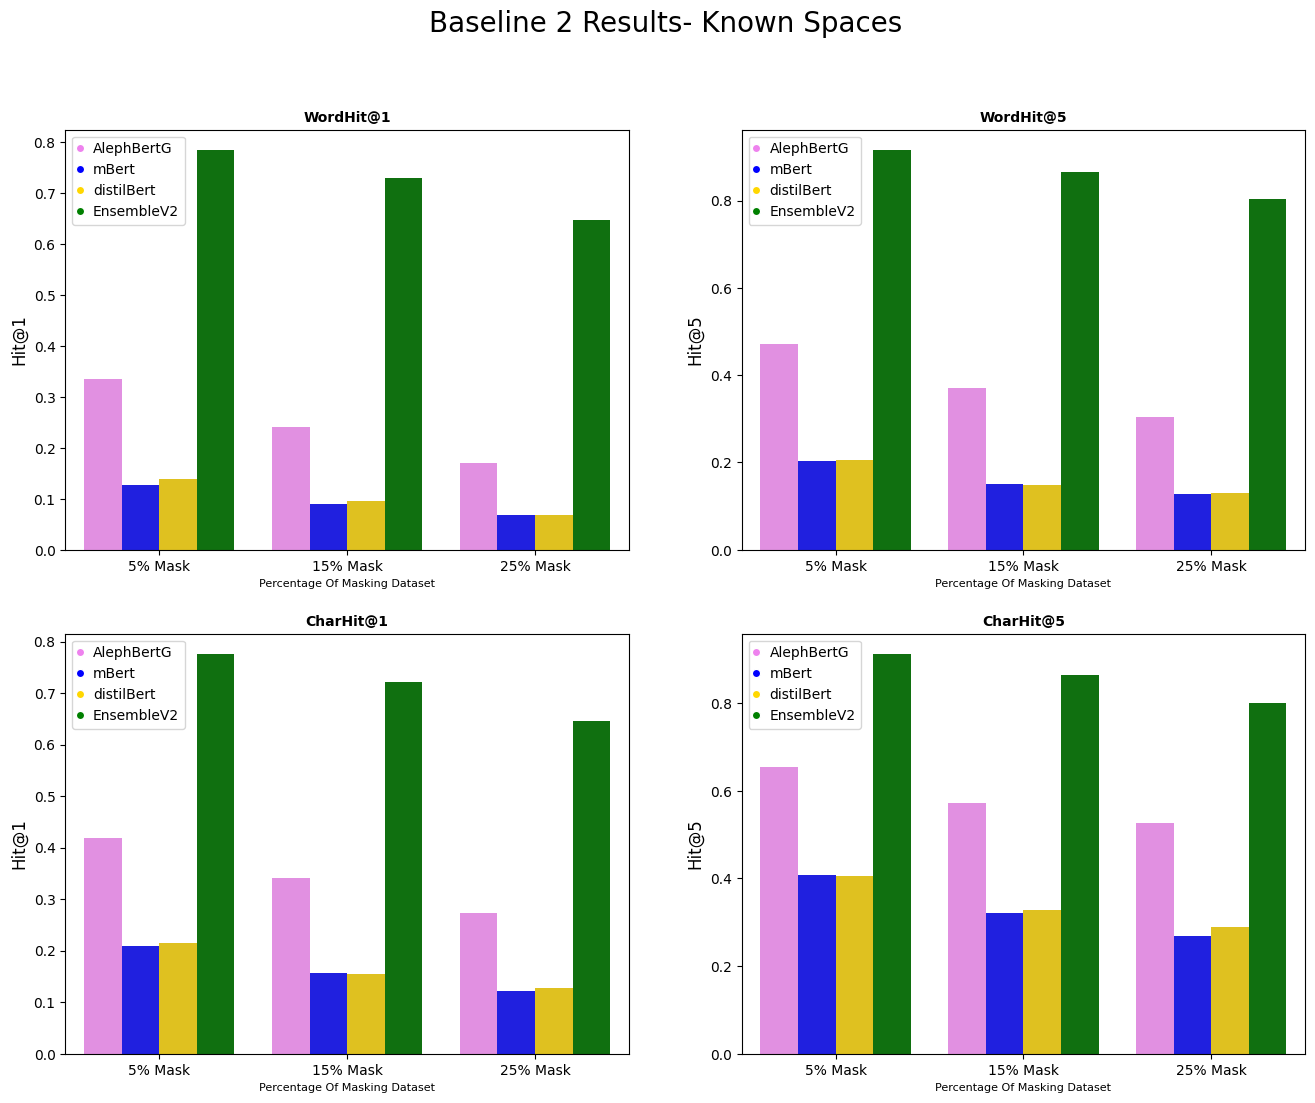

In [9]:
plot_Compare_result_ensemble_finetune(lst_merges_by_metric,["violet", "blue","gold",'green'],unique_values,'Baseline 2 Results- Known Spaces')

## **Baseline 1 Graph:**

In [10]:
def plot_Baseline1(lst_merges_by_metric,colors1,unique_values,model_name):
  fig, axs = plt.subplots(1, 2, figsize=(12, 8))
  flag=False
  for i,eval in enumerate(['Word']):
      for j,k in enumerate([1,5]):
        sns.barplot(x='file', y='hit@k',data=lst_merges_by_metric[j],hue='model',palette=colors1, ax=axs[j])
        axs[j].set_title(eval+ "Hit@"+str(k), fontsize=10, fontweight="bold")
        axs[j].set_xlabel("Percentage Of Masking Dataset", fontsize=8)
        axs[j].set_ylabel("Hit@"+str(k), fontsize=12)
        legend_elements2 = [plt.Line2D([0], [0],marker='o', color='w', label=unique_values[0], markerfacecolor=colors1[0], markersize=6),
                      plt.Line2D([0], [0], marker='o', color='w', label=unique_values[1], markerfacecolor=colors1[1], markersize=6),
                      plt.Line2D([0], [0],marker='o', color='w', label=unique_values[2], markerfacecolor=colors1[2], markersize=6),
                      plt.Line2D([0], [0],marker='o', color='w', label=unique_values[3], markerfacecolor=colors1[3], markersize=6)]        
        axs[j].legend(handles=legend_elements2,loc='upper right',handlelength=0.3)


  fig.suptitle(model_name, fontsize=20)
  fig.savefig("baseline1results.png")

In [11]:
lst_merges_by_metric2=[]
for df in new_df2:
  df=df.loc[df['model'].isin(['Embible/AlephBertGimmel-20-epochs','Embible/mBert-50-epochs','Embible/distilBert-50-epochs','Embible/improvedABG-50-epochs','EnsembleV2'])]
  lst_merges_by_metric2.append(df)

In [12]:
words1_emsemnle_baseline1 = [lst_merges_by_metric2[0],lst_chars_words_ensemble[1][0]]
words1_merge_ensemble_baseline = pd.concat(words1_emsemnle_baseline1, axis=0, ignore_index=True)
words5_emsemnle_baseline1=[lst_merges_by_metric2[1],lst_chars_words_ensemble[1][1]]
words5_emsemnle_baseline = pd.concat(words5_emsemnle_baseline1, axis=0, ignore_index=True)

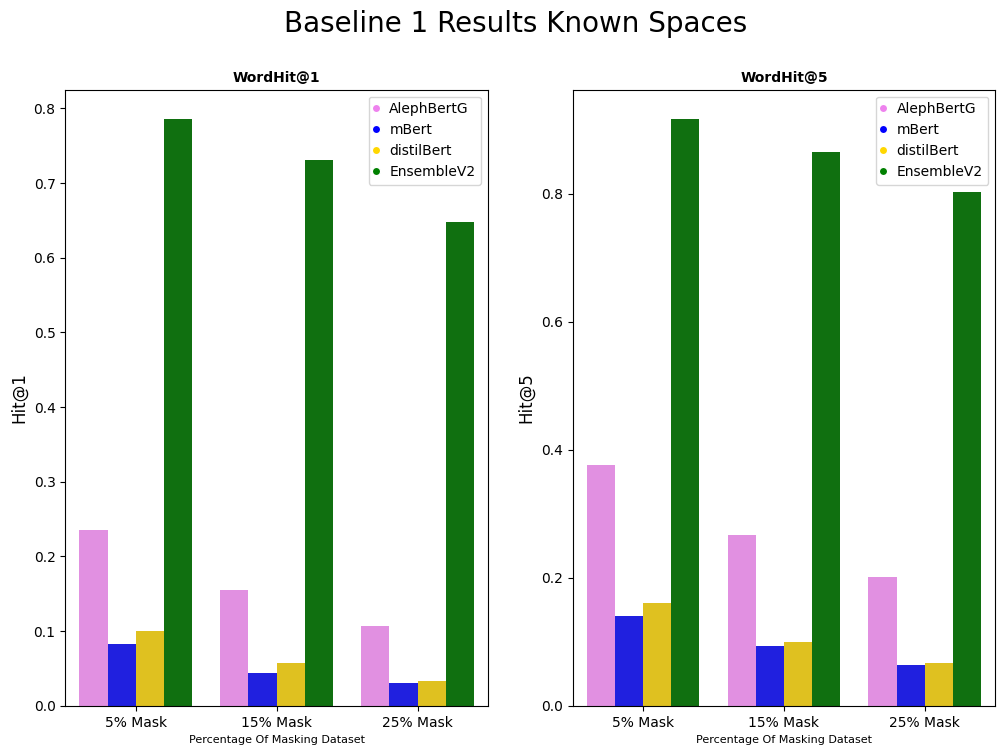

In [13]:
plot_Baseline1([words1_merge_ensemble_baseline,words5_emsemnle_baseline],["violet", "blue","gold","green"],unique_values,'Baseline 1 Results Known Spaces')